James Telzrow \
2023-07-05 \
Warburton Lab \
Quantum Harmonic Oscillator and Fourier Grid Hamiltonian Approximation

## Introduction

This notebook contains an implementation of the Fourier Grid Hamiltonian method for computing bound state eigenvalues (discrete energy quantities) and eigenfunctions (wavefunctions) of the Schrodinger equation, as described in the following paper:

1. C. Clay Marston, Gabriel G. Balint‐Kurti; The Fourier grid Hamiltonian method for bound state eigenvalues and eigenfunctions. *J. Chem. Phys.* 15 September 1989; 91 (6): 3571–3576.

For brevity, the implementation here omits any descriptive comments. Please see  the Fourier Grid Hamiltonian Implementation notebook (from which most of the FGH code in this notebook has been copied and pasted) in this repo for more information on the details of this implementation.

Suppose that there exists a particle in a one-dimensional space (that is, on the  x-axis.)
Let this particle have mass `mass` in atomic mass units, a definite quantity of energy, and potential energy $V(x)$ (in electronvolts) when the particle is at point $x$.
Suppose that the values of $V(x)$ at specific points are given by the contents of a two-column [Comma-Separated Value](https://en.wikipedia.org/wiki/Comma-separated_values) file.
That is, given any particular row in said CSV file, the first element in the row specifies a position on the x-axis (in Angstroms) and the second specifies the amount of energy (in electronvolts) that the particle posesses when it is at that position.

The code in this notebook uses the Fourier Grid Hamiltonian method described in [1] to numerically approximate the wavefunctions of the particle and the fixed quantities of energy that correspond to these wavefunctions.

Additionally, it fits a parabola of the form $\frac{k}{2}(x-x_0)^2$ to the supplied potential energy data, and then analytically solves the Time-Independent Schrodinger Equation for the Quantum Harmonic Oscillator, using this parabola as the potential energy function.

Finally, it plots the approximations created using the FGH method as well as the analytical solutions created for the Quantum Harmonic Oscillator, shifting the graph of each wavefunction vertically by the amount of energy (in electronvolts) that the particle/QHO possesses at that energy level.

In order to perform these calculations, several parameters must be set:

* The name of/path to the CSV file containing the potential energy data must be specified using the `potential_energy_csv` variable.

* The degree of the B-spline that will be created as an interpolant of the supplied potential energy data and used in the FGH calculation must be specified using the `spl_ord` variable, which must be a positive integer.

* The interval on which the wavefunctions will be computed using FGH and will be  plotted (on the x-axis in Angstroms) must be  specified using the `interval_for_sol` variable, which must be a 2-element list of integers or floats in which the second element is greater than the first.

* The energy levels for which the analytic solutions for the Quantum Harmonic Oscillator will be calculated and for which both FGH and QHO solutions will be plotted must be specified using the `energy_levels_to_plot` variable.

* The mass (in atomic units) of the particle for which the energy quantities and wavefunctions will be computed must be specified by setting the `mass` variable, which must be a positive integer or float.

* The step size (in Angstroms) which will be used in the FGH calculation and when evaluating the analytical QHO solution in order to plot it must be specified by setting the `step_size` variable, which must be a nonnegative integer or float.

All of the variables mentioned above are located in the cell entitled **Configure Parameters And Load Data**

To perform an FGH and QHO calculation, several cells must be executed in the following order:

1. The parameter values and name of/path to the potential energy data CSV file must be specified in the **Configure Parameters and Load Data** cell, and that cell must be run.

2. The cell entitled **Prepare Data** must  be run.

3. THe cell entitled **FGH and QHO Solver Implementations** must be run.

4. The cell entitled **Perform FGH and QHO Computations** must be run.

5. To visualize the newly computed energy quantities and wavefunctions, the cell entitled **Visualize Solutions** must be run.
Note that the wavefunctions will be vertically shifted by their corresponding energy quantity (in electronvolts), and the potential energy curve will be plotted as well (although if the `restrict_plot_range_to_wavefuncs` variable is set to True, then the range of the vertical axes of the graphs will be restricted to keep the wavefunctions in focus, and thus some of the potential energy curve may not be displayed.)

## Configure Parameters And Load Data

In [1]:
# Name of/path to CSV file containing potential energy data
potential_energy_csv = 'pot.csv'
# The order of the B-spline that will be created from the potential 
# energy data
spl_ord = 3

# The interval on which the wavefunctions will be found and plotted (on 
# the x-axis, in Angstroms)
interval_for_sol = [-10, 10]
# The indices of the energy levels for which to plot wavefunctions, from
# a zero-indexed list of energy levels (in electron volts) sorted by
# increasing magnitude.
energy_levels_to_plot = [0, 1, 2, 3, ]

# The mass of the particle, in atomic mass units
mass = 0.0005
# The magnitude of the difference between adjacent points on the x-axis
# at which the wavefunction values will be computed using the FGH 
# method, and at which the analytical solutions for QHO will be 
# evaluated, in Angstroms
step_size = 0.1

## Prepare Data

In [2]:
import numpy as np
from scipy.interpolate import make_interp_spline

# Convert atomic units to kilograms
m = mass * 1.660_540_199e-27
# Convert Angstroms to meters
delta_x = step_size * 1e-10

# Potential energy data, in Angstroms vs electronvolts
p_e_d_A_ev = np.loadtxt(potential_energy_csv, delimiter=',')
# Convert Angstroms to meters and electronvolts to Joules
p_e_d = np.column_stack((p_e_d_A_ev[:, 0]*1e-10,
                         p_e_d_A_ev[:, 1]*1.602_176_634e-19))
# By default, the BSpline returned by this function has extrapolate =
# True
potential_energy_bspl = make_interp_spline(
    p_e_d[:, :1].flatten(), p_e_d[:, 1:2].flatten(), k=spl_ord)


def potential_for_fgh(x) -> float:
    # Gives the potential energy of the particle (in Joules), given its 
    # position on the x-axis (in meters)
    return potential_energy_bspl(x)


def kronecker_delta_function(coords: [int]):
    if coords[0] == coords[1]:
        return 1
    else:
        return 0


# Convert Angstroms to meters
interval_lower_bound = interval_for_sol[0] * 1e-10
interval_upper_bound = interval_for_sol[1] * 1e-10
# The points on the x-axis at which the values of the wavefunctions will
# be found
grid_points = np.arange(interval_lower_bound, interval_upper_bound, delta_x)
# The FGH algorithm requires an odd number of grid points; drop one if
# arange returns an even number of points
if grid_points.size % 2 != 1:
    grid_points = grid_points[:-1]

# Make sure the user hasn't asked for an energy level higher than that
# which we are able to find using the FGH method
for e_lvl in energy_levels_to_plot:
    if (e_lvl > grid_points.size - 1):
        int_ln = interval_for_sol[1] - interval_for_sol[0]
        raise ValueError('Because the specified interval is {} Angstroms long '
                         'and the specified step size is {}, the FGH method '
                         'can compute only {} energy levels (0 through {}). '
                         ' However, energy_levels_to_plot contains the value '
                         '{}, which is an energy level higher than that which '
                         'can be computed using the FGH method. Please remove '
                         'that value from energy_levels_to_plot and try again.'
                         .format(int_ln, delta_x, grid_points.size,
                                 grid_points.size - 1, e_lvl))

# The result of this is technically a float, but because
# grid_points.size is always odd, we can cast this to an integer without
# losing any information
N = grid_points.size
n = int((N - 1)/2)

# Reduced Planck constant, in Joule seconds
hbar = 1.054_571_817e-34

# The element at position [x, y] in this array will be the 2-element
# array [x, y].
matrix_indices = np.indices((N, N)).transpose((1, 2, 0))
# Equivalent to iterating across each row of the matrix above, and
# adding every 2-element array to a one-dimensional list
matrix_indices = matrix_indices.reshape((N**2, 2))

# Create an empty matrix that will become the Hamiltonian matrix once
# elements are calculated by the code below
hamiltonian = np.zeros((N, N))


## FGH and QHO Solver Implementations

In [3]:
from math import cos as mth_cos
from math import pi as mth_pi
from math import sqrt as mth_sqrt
from sympy import exp, integrate, lambdify, limit, oo, Rational, simplify, \
    sqrt, Symbol, symbols


def get_QHO_potential_coefs(p_e_d):
    """
    Determines values of k and x_0 for a polynomial of the form 
    (k/2)(x-x_0)^2 (which is the function describing the potential 
    energy of the Quantum Harmonic Oscillator) that are fit to p_e_d, an
    array of potential energy data.
    """
    # Sort datapoints from least x-coordinate to greatest x-coordinate
    p_e_d = p_e_d[p_e_d[:, 0].argsort()]
    # Find the x-coordinate of the leftmost minimum point
    leftmost_min_val_index = p_e_d[:, 1].argmin()
    x_coord_of_min_val = p_e_d[leftmost_min_val_index, 0]

    # Take all of the points to the left of the leftmost minimum point,
    # and reflect them across the vertical line passing through
    # x_coord_of_min_val. Since we sorted the list in order of
    # increasing x_coordinate, these points are all those at an index
    # less than leftmost_min_val_index
    points_left_of_min = p_e_d[0:leftmost_min_val_index]
    # Perform reflection
    points_left_of_min[:, 0] = x_coord_of_min_val + \
        abs(points_left_of_min[:, 0] - x_coord_of_min_val)
    # Concatenate reflection of points left of minimum with points right
    # of minimum
    reflected_left_of_min = np.concatenate(
        (points_left_of_min, p_e_d[leftmost_min_val_index:]))
    # If any of the points are negative (which they shouldn't be because
    # they represent potential energy), replace them with zero to avoid
    # an error when taking the square root
    reflected_left_of_min[:, 1][reflected_left_of_min[:, 1] < 0] = 0
    # Rename for clarity
    non_neg_r_l_o_m = reflected_left_of_min
    # The values should be roughly parabolic, so this should produce a
    # linear "vee" shape,
    sq_rt_r_l_o_m = np.column_stack(
        (non_neg_r_l_o_m[:, 0], np.sqrt(non_neg_r_l_o_m[:, 1])))

    # Create a degree one polynomial fit to the square root of the data
    deg_1_poln_coefs = np.polyfit(
        sq_rt_r_l_o_m[:, 0], sq_rt_r_l_o_m[:, 1], deg=1)
    # Determine the spring constant, k
    k = 2*deg_1_poln_coefs[0]**2
    # Determine the point at which the particle has minimum potential
    # energy, x_0
    x_0 = -1*deg_1_poln_coefs[1]*mth_sqrt(deg_1_poln_coefs[0]**-2)

    return k, x_0

# The following three functions are essentially copied and pasted from
# the Schrodinger Time Independent Equation with Quadratic Potential
# (Quantum Harmonic Oscillator) notebook, which is also in this repo.
# Detailed explanations of these functions are found in that notebook.


def create_nonnormalized_dimensionless_soln(energy_level: int,
                                            first_coef_pos: bool,
                                            u: Symbol):
    coefficients = []
    energy_level_even = False
    if energy_level % 2 == 0:
        energy_level_even = True
    lowest_order_coef = None
    if not first_coef_pos:
        first_coef_pos = None
    if energy_level_even:
        coefficients.append(Symbol('a_0', positive=first_coef_pos))
        coefficients.append(0)
    else:
        coefficients.append(0)
        coefficients.append(Symbol('a_1', positive=first_coef_pos))
    for index in range(2, energy_level+1):
        if (energy_level % 2 == 0 and index % 2 == 0) or (energy_level % 2 == 1
                                                          and index % 2 == 1):
            i_m_2 = index-2
            coefficients.append(
                (2*i_m_2 - 2*(energy_level+Rational(1, 2)) + 1) *
                coefficients[i_m_2] / ((i_m_2 + 2)*(i_m_2 + 1))
            )
        else:
            coefficients.append(0)
    h_n = 0
    for index in range(energy_level+1):
        h_n = h_n + coefficients[index] * u**index
    return h_n * exp(-u**2 / 2), coefficients


def create_normalized_solution(energy_level: int, first_coef_pos: bool):
    u = Symbol('u')
    nn_d_s, coefs = create_nonnormalized_dimensionless_soln(
        energy_level=energy_level, first_coef_pos=first_coef_pos, u=u)
    energy_level_even = False
    if energy_level % 2 == 0:
        energy_level_even = True
    if energy_level_even:
        factored_out_coefficient = coefs[0]
    else:
        factored_out_coefficient = coefs[1]
    factored_nnds = simplify(nn_d_s/factored_out_coefficient)
    nnds_antideriv_mag_sq = abs(factored_out_coefficient)**2 * \
        integrate(factored_nnds**2, u)
    alpha = Symbol('alpha', positive=True)
    x, x_0_symb = symbols('x x_0')
    u_expr = (x-x_0_symb)/(alpha)
    nns_antideriv_mag_sq = nnds_antideriv_mag_sq.subs(u, u_expr) * alpha
    norm_factor = sqrt(limit(nns_antideriv_mag_sq, x, oo) -
                       limit(nns_antideriv_mag_sq, x, -oo))
    normalized_solution = nn_d_s.subs(u, u_expr) / norm_factor
    return normalized_solution, x, x_0_symb, alpha


def QHO_compute_solution(solution_vals, solution_magnitude_squared_vals,
                         energies, energy_levels, hbar, m, k, x_0_m,
                         eval_points):
    for e_lvl in energy_levels:
        soln_and_vars = create_normalized_solution(
            energy_level=e_lvl, first_coef_pos=True)
        soln = soln_and_vars[0].subs({
            soln_and_vars[3]: sqrt(hbar/(m*sqrt(k/m))),
            soln_and_vars[2]: x_0_m,
        })
        lambdified_soln = lambdify([soln_and_vars[1]], soln, 'numpy')
        solution_vals[e_lvl] = lambdified_soln(eval_points)
        solution_magnitude_squared_vals[e_lvl] = np.square(
            solution_vals[e_lvl])
        energies[e_lvl] = hbar*sqrt(k/m)*(e_lvl + 0.5)

# The following two functions are essentially copied and pasted from
# the Fourier Grid Hamiltonian Implementation notebook, which is also in
# this repo. Explanations of these functions are found in that notebook.


def compute_hamiltonian_sum_term(summation_index, i, j, m, hbar, delta_x, N):
    l = summation_index
    T_l = (2/m)*((hbar*mth_pi*l)/(N*delta_x))**2
    return mth_cos(l*2*mth_pi*(i - j)/N)*T_l


def compute_unique_hamiltonian_element(coords, m, hbar, delta_x, N, n,
                                       potential):
    if coords[0] <= coords[1]:
        summation_indices = np.arange(1, n+1)
        v_c_h_s_t = np.vectorize(compute_hamiltonian_sum_term)
        v_c_h_s_t.excluded.add((1, 2, 3, 4, 5, 6))
        sum = (2/N)*v_c_h_s_t(summation_indices,
                              *coords, m, hbar, delta_x, N).sum()
        sum += potential(grid_points[coords[0]]) * \
            kronecker_delta_function(coords)
        hamiltonian[*coords] = sum


## Perform FGH and QHO Computation

In [4]:
from scipy import linalg


# A dictionary mapping energy level numbers to the corresponding
# analytic Quantum Harmonic Oscillator solutions evaluated on the given
# interval at the given number of points
analytic_QHO_sol_vals = dict()
# A dictionary mapping energy level numbers to the squared magnitude of
# the corresponding analytic Quantum Harmonic Oscillator solutions.
# Created by squaring the magnitude of the values in
# analytic_QHO_sol_vals
mag_sq_analytic_QHO_sol_vals = dict()
# A dictionary mapping energy level numbers to the amount of energy (in
# Joules) that the Quantum Harmonic Oscillator has when it is in that
# energy level.
analytic_QHO_energies = dict()

# Get the coefficients of the Quantum Harmonic Oscillator potential
# energy function that best fits the supplied data
k, x_0_m = get_QHO_potential_coefs(p_e_d)

QHO_compute_solution(analytic_QHO_sol_vals, mag_sq_analytic_QHO_sol_vals,
                     analytic_QHO_energies, energy_levels_to_plot, hbar, m, k, 
                     x_0_m, grid_points)


def compute_unique_hamiltonian_element_with_params(coords):
    compute_unique_hamiltonian_element(coords, m, hbar, delta_x, N, n,
                                       potential_for_fgh)


def compute_conjugate_hamiltonian_element(coords):
    # This function is also copied and pasted from the Fourier Grid
    # Hamiltonian Implementation notebook. An explanation of why this
    # function does what it does is available there.
    if coords[0] > coords[1]:
        hamiltonian[*coords] = hamiltonian[*coords[::-1]]


# Compute the elements of the Hamiltonian matrix on and above the main
# diagonal
np.apply_along_axis(
    compute_unique_hamiltonian_element_with_params, 1, matrix_indices)
# Compute the elements of the Hamiltonian matrix below the main diagonal
# (very simple because the matrix is Hermetian and has all real
# elements)
np.apply_along_axis(compute_conjugate_hamiltonian_element, 1, matrix_indices)
# Find the eigenvalues (energy levels) and eigenvectors (wave functions)
# of the Hamiltonian matrix
hamiltonian_eig = linalg.eig(hamiltonian)
hamiltonian_eigenvals = hamiltonian_eig[0]
hamiltonian_eigenvects = hamiltonian_eig[1]
# Evaluate the potential energy for the FGH calculation at every grid 
# point
pot_eng_vals_fgh = potential_for_fgh(grid_points)
# Evaluate the potential energy curve for the QHO at every grid point
pot_eng_vals_qho = (k/2)*(grid_points - x_0_m)**2

## Visualize Solutions

Energy levels: (in electronvolts)
Energy level 0: 1.5179842007013067
Energy level 1: 4.553952600357061
Energy level 2: 7.589920980300604
Energy level 3: 10.62588922786936


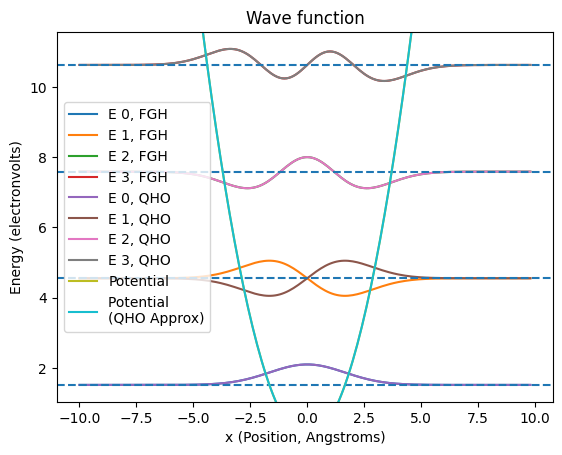

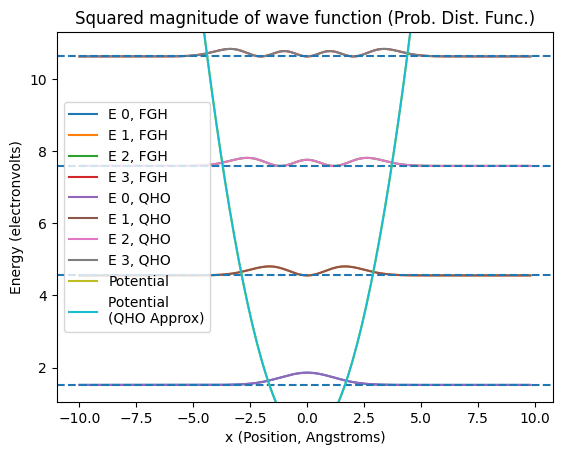

In [5]:
import matplotlib.pyplot as plt
from scipy import integrate

# If the potential is very large relative to the wavefunctions, then the
# wavefunctions, then the wavefunctions would appear as closely spaced,
# indiscernable lines at the bottom of the graph, which is not
# desirable. To avoid this, set restrict_plot_range_to_wavefuncs to True
# to restrict the range of the vertical axes of both graphs to
# (approximately) the minimum and maximum values of the wavefunctions
# and squared wavefunctions to be plotted.
restrict_plot_range_to_wavefuncs = True

print('Energy levels: (in electronvolts)')

srt_ham_egv = hamiltonian_eigenvals.argsort()

# A list containing normalized solutions/wavefunctions created using the
# FGH method. The element at the ith index of this list should be a
# numpy array containing the solution for the energy level at the ith
# index of nergy_levels_to_plot.
norm_fgh_solns = []

# Convert Joules to electron volts
pot_eng_ev_fgh = pot_eng_vals_fgh * 6.241_509_074e18
pot_eng_ev_qho = pot_eng_vals_qho * 6.241_509_074e18

# Normalize solutions computed with FGH method
for _, egv_index in enumerate(srt_ham_egv.take(energy_levels_to_plot)):
    # Convert meters to Angstroms
    grid_points_A = grid_points * 1e10
    soln_int = integrate.simpson(
        hamiltonian_eigenvects[:, egv_index]**2, grid_points_A)
    norm_fgh_solns.append(
        hamiltonian_eigenvects[:, egv_index]/mth_sqrt(soln_int))

norm_fgh_solns = np.array(norm_fgh_solns)

# Convert Joules to electronbolts
nrg_quant_fgh = np.absolute(hamiltonian_eigenvals[srt_ham_egv.take(
    energy_levels_to_plot)] * 6.241_509_074e18)

# Normalized FGH solutions plus the amount of energy (in electronvolts)
# corresponding to each solution (essentially shifting the graphs of
# these solutions horizontally)
norm_fgh_solns_pl_nrg = norm_fgh_solns + np.repeat(
    nrg_quant_fgh.reshape(len(energy_levels_to_plot), 1),
    repeats=norm_fgh_solns.shape[1], axis=1)

# The largest and smallest values of any of the wavefunctions plus
# energy to be plotted on the interval on which they will be plotted,
# and the magnitude of the difference between them.
max_wavefunc_val = norm_fgh_solns_pl_nrg.max()
min_wavefunc_val = norm_fgh_solns_pl_nrg.min()
wavefunc_range = max_wavefunc_val - min_wavefunc_val

# Plot the wavefunctions computed with the FGH method
for index, e_lvl in enumerate(energy_levels_to_plot):
    print('Energy level {}: {}'
          .format(e_lvl, nrg_quant_fgh[index]))
    # Convert meters to Angstroms
    plt.plot(grid_points * 1e10,
             norm_fgh_solns_pl_nrg[index], label='E {}, FGH'.format(e_lvl))

# Plot the wavefunctions computed for the Quantum Harmonic Oscillator
for e_lvl in energy_levels_to_plot:
    # Convert Joules to electronvolts
    energy_ev = analytic_QHO_energies[e_lvl] * 6.241_509_074e18
    # Convert meters to Angstroms (essentially stretch the x-axis by a
    # factor of 1e10)
    eval_points_A = grid_points * 1e10
    # Since we stretched the x-axis by a factor of 1e10, and since we
    # must have that the integral of the squared magnitude of
    # solution_vals[e_lvl] across the interval on which we are solving
    # equals one, we must scale the y-axis by a factor of 1e-5
    sol_vals_pl_nrg = analytic_QHO_sol_vals[e_lvl] * 1e-5 + energy_ev
    # Update minimum, maximum and range if necessary
    if sol_vals_pl_nrg.max() > max_wavefunc_val:
        max_wavefunc_val = float(sol_vals_pl_nrg.max())
        wavefunc_range = max_wavefunc_val - min_wavefunc_val
    if sol_vals_pl_nrg.min() < min_wavefunc_val:
        min_wavefunc_val = float(sol_vals_pl_nrg.min())
        wavefunc_range = max_wavefunc_val - min_wavefunc_val
    plt.plot(eval_points_A, sol_vals_pl_nrg, label='E {}, QHO'.format(e_lvl))
    plt.axhline(y=energy_ev, linestyle='dashed')

# Convert meters to Angstroms and plot the potential energy curves
plt.plot(grid_points * 1e10, pot_eng_ev_fgh, label='Potential')
plt.plot(grid_points * 1e10, pot_eng_ev_qho, label='Potential \n(QHO Approx)')
if restrict_plot_range_to_wavefuncs:
    plt.ylim((min_wavefunc_val - wavefunc_range * 0.05,
              max_wavefunc_val + wavefunc_range * 0.05))
plt.xlabel('x (Position, Angstroms)')
plt.ylabel('Energy (electronvolts)')
plt.title('Wave function')
plt.legend()
plt.show()

# Normalized squared FGH solutions plus the amount of energy (in 
# electronvolts) corresponding to each squared solution (essentially 
# shifting the graphs of these squared solutions horizontally)
norm_sq_fgh_solns_pl_nrg = norm_fgh_solns**2 + np.repeat(
    nrg_quant_fgh.reshape(len(energy_levels_to_plot), 1),
    repeats=norm_fgh_solns.shape[1], axis=1)

# The largest and smallest values of any of the squared wavefunctions 
# plus energy to be plotted on the interval on which they will be 
# plotted, and the magnitude of the difference between them.
max_sq_wavefunc_val = norm_sq_fgh_solns_pl_nrg.max()
min_sq_wavefunc_val = norm_sq_fgh_solns_pl_nrg.min()
sq_wavefunc_range = max_sq_wavefunc_val - min_sq_wavefunc_val

# Plot the squared magnitude of the wavefunctions computed with the FGH
# method
for index, e_lvl in enumerate(energy_levels_to_plot):
    # Convert meters to Angstroms
    plt.plot(grid_points * 1e10,
             norm_sq_fgh_solns_pl_nrg[index], label='E {}, FGH'.format(e_lvl))

# Plot  the squared magnitude of the wavefunctions computed for the
# Quantum Harmonic Oscillator
for e_lvl in energy_levels_to_plot:
    # Convert Joules to electronvolts
    energy_ev = analytic_QHO_energies[e_lvl] * 6.241_509_074e18
    # Convert meters to Angstroms (essentially stretch the x-axis by a
    # factor of 1e10)
    eval_points_A = grid_points * 1e10
    # Since we stretched the x-axis by a factor of 1e10, and since we
    # must have that the integral of the squared magnitude of the
    # solution across the interval on which we are solving equals one,
    # we must scale the y-axis by a factor of 1e-10.
    sol_mg_sq_pl_nrg = mag_sq_analytic_QHO_sol_vals[e_lvl] * 1e-10 + energy_ev
    # Update minimum, maximum and range if necessary
    if sol_mg_sq_pl_nrg.max() > max_sq_wavefunc_val:
        max_sq_wavefunc_val = float(sol_mg_sq_pl_nrg.max())
        sq_wavefunc_range = max_sq_wavefunc_val - min_sq_wavefunc_val
    if sol_mg_sq_pl_nrg.min() < min_sq_wavefunc_val:
        min_sq_wavefunc_val = float(sol_mg_sq_pl_nrg.min())
        sq_wavefunc_range = max_sq_wavefunc_val - min_sq_wavefunc_val
    plt.plot(eval_points_A, sol_mg_sq_pl_nrg, label='E {}, QHO'.format(e_lvl))
    plt.axhline(y=energy_ev, linestyle='dashed')

# Convert meters to Angstroms and plot the potential energy curves
plt.plot(grid_points * 1e10, pot_eng_ev_fgh, label='Potential')
plt.plot(grid_points * 1e10, pot_eng_ev_qho, label='Potential \n(QHO Approx)')
if restrict_plot_range_to_wavefuncs:
    plt.ylim((min_sq_wavefunc_val - sq_wavefunc_range * 0.05,
              max_sq_wavefunc_val + sq_wavefunc_range * 0.05))
plt.xlabel('x (Position, Angstroms)')
plt.ylabel('Energy (electronvolts)')
plt.title('Squared magnitude of wave function (Prob. Dist. Func.)')
plt.legend()
